In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.misc
from scipy import ndimage
from six.moves import cPickle as pickle

mpl.rcParams['figure.figsize'] = 10, 10
type_name = {
    0: "circles",
    1: "vertical_lines",
    2: "horizontal_lines",
#    3: "zeros",
#    4: "up_triangles",
#    5: "down_triangles"
}

In [2]:
# Create grid for data images
# img = np.ones([1009, 1009])
# k = 100
# for i in range(9):
#    for j in range(1009):
#        img[k, j] = 0
#        img[j, k] = 0
#    k += 101

# plt.imshow(img, cmap='gray')
# scipy.misc.imsave('data_for_recognition/pattern.jpg', img)

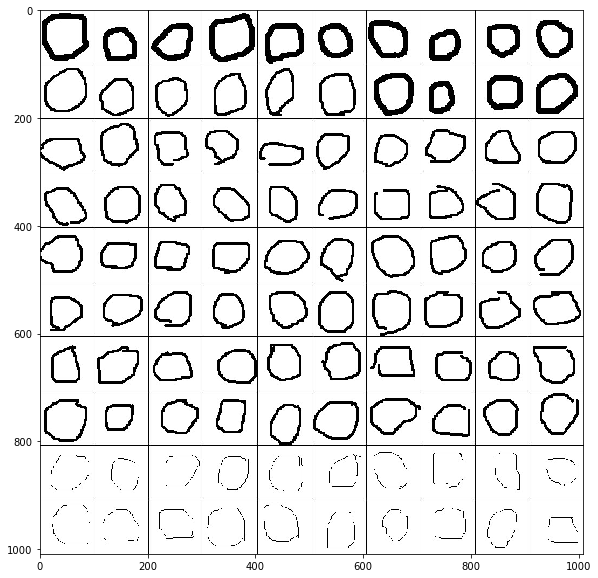

In [3]:
img_name = 'circles'
img = ndimage.imread('data_for_recognition/' + img_name + '.jpg', flatten = True).astype(int) / 255
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
def search_zeros(img):
    shape = img.shape
    points = []
    for i in range(shape[0]):
        for j in range(shape[1]):
            if img[i, j] == 0:
                points.append((i, j))
    return points

def generalize_img(img, img_size):
    points = search_zeros(img)
    max_x = max([x[0] for x in points])
    min_x = min([x[0] for x in points])
    max_y = max([x[1] for x in points])
    min_y = min([x[1] for x in points])
    delta = max(max_x - min_x, max_y - min_y) / (img_size - 1)
    new_points = set()
    for x, y in points:
        new_points.add(((int((x - min_x) / delta)),(int((y - min_y) / delta))))
    
    img = np.zeros([img_size, img_size])
    for point in new_points:
        img[point[0], point[1]] = 255
    return img

for name in type_name.values():
    img = ndimage.imread('data_for_recognition/' + name + '.jpg', flatten = True).astype(int) / 255
    for i in range(10):
        for j in range(10):
            small_img = img[101 * i:101 * i + 100, 101 * j:101 * j + 100]
            new_small_img = generalize_img(small_img, 15)
            scipy.misc.imsave('data_for_recognition/' + name + '/' + str(10 * i + j) + '.png', new_small_img)

In [5]:
def make_arrays(nb_rows, img_size):
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
    return dataset, labels

class_size = 100
tr_size_per_class = 70
ts_size_per_class = 15
vl_size_per_class = 15
img_size = 15
num_classes = len(type_name)

train_dataset, train_labels = make_arrays(num_classes * tr_size_per_class, img_size)
test_dataset, test_labels = make_arrays(num_classes * ts_size_per_class, img_size)
valid_dataset, valid_labels = make_arrays(num_classes * vl_size_per_class, img_size)

start_tr = 0
end_tr = tr_size_per_class
start_ts = 0
end_ts = ts_size_per_class
start_vl = 0
end_vl = vl_size_per_class

for class_index, class_name in type_name.items():
    class_set = np.ndarray([class_size, img_size, img_size])
    for i in range(class_size):
        class_set[i, :, :] = ndimage.imread('data_for_recognition/' + class_name + '/' + str(i) + '.png', flatten = True
                                          ).astype(int) / 255 - 0.5
    np.random.shuffle(class_set)
    
    train_dataset[start_tr:end_tr, :, :] = class_set[:tr_size_per_class, :, :]
    train_labels[start_tr:end_tr] = class_index
    start_tr += tr_size_per_class
    end_tr += tr_size_per_class 
    
    test_dataset[start_ts:end_ts, :, :] = class_set[tr_size_per_class:tr_size_per_class + ts_size_per_class, :, :]
    test_labels[start_ts:end_ts] = class_index
    start_ts += ts_size_per_class
    end_ts += ts_size_per_class   
    
    valid_dataset[start_vl:end_vl, :, :] = class_set[tr_size_per_class + vl_size_per_class:, :, :]
    valid_labels[start_vl:end_vl] = class_index
    start_vl += ts_size_per_class
    end_vl += ts_size_per_class 
    
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(210, 15, 15) (210,)
(45, 15, 15) (45,)
(45, 15, 15) (45,)


In [6]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [7]:
pickle_file = 'data_for_recognition/pickled_data'
f = open(pickle_file, 'wb')
save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()